In [3]:
#Array packages
import pandas as pd
import numpy as np
import xarray as xr
import netCDF4 as nc4

from scipy.stats import kendalltau

#plots
import matplotlib.pyplot as plt
import rioxarray as rio
import geopandas as gpd
from shapely.geometry import mapping
import matplotlib.ticker as ticker
import cartopy.feature as cfeature
from matplotlib.patches import Circle
import matplotlib.patches as mpatches
import cartopy.crs as ccrs

#Progress meter
from dask.diagnostics import ProgressBar
from tqdm import tqdm

# Directories
import os
import glob
import dask
#import h5netcdf
import scipy

import os
os.chdir(r"G:\OneDrive - IIT Delhi\3. IIT DELHI\2. Research\2_Papers\1_Streamflow Trend analysis")
print(os.getcwd())

G:\OneDrive - IIT Delhi\3. IIT DELHI\2. Research\2_Papers\1_Streamflow Trend analysis


## 1 Streamflow Average

In [4]:
data1=sorted(glob.glob(f'3_Data/Data_r/1_ILDAS/*.nc*'))
ds = xr.open_mfdataset(data1, combine='by_coords',engine='netcdf4', parallel=True,chunks={'time': 'auto'})
ds

dataset=[]
season=['Pre-monsoon','Monsoon','Post-monsoon','Winter']
ssn=[[3,4,5],[6,7,8,9],[10,11],[12,1,2]]
for s in ssn:

    dt=ds["Streamflow_tavg"].sel(time=ds['time.month'].isin(s)).mean(dim='time').compute()
    dataset.append(dt)

plt_tit=season
cbar_tit='Stream flow (Cumic)'
main_tit=''
Map_plot1(dataset,[2,2],plt_tit,cbar_tit)  
plt.savefig(r'2_Streamflow_Analysis\2_basic_statistics\Outputs', bbox_inches='tight',dpi=1000)

OSError: [Errno -51] NetCDF: Unknown file format: b'G:\\OneDrive - IIT Delhi\\3. IIT DELHI\\2. Research\\2_Papers\\1_Streamflow Trend analysis\\3_Data\\Data_r\\1_ILDAS\\ROUTING_full1.nc'

: 

## 2_streamflow indices average



In [10]:
## Season
ssn=['Pre-monsoon','Monsoon','Post-monsoon','Winter']
ssn_n=[[3,4,5],[6,7,8,9],[10,11],[12,1,2]]
ds_drt=[];ds_fld=[]

data1=sorted(glob.glob(f'3_Data/Data_r/1_ILDAS/*.nc*'))
data = xr.open_mfdataset(data1, combine='by_coords',engine='netcdf4', parallel=True,chunks={'time': 'auto'})
data = data.sel(lon=data['lon'][::6],lat=data['lat'][::6],time=slice('1975','2022'))
data = data.chunk({'time': -1}).compute()
for s in tqdm(range(4)):

    ## drt
    drt_ssn=data['Streamflow_tavg'].sel(time=data["time.month"].isin(ssn_n[s])).rolling(time=7).mean().resample(time='YE').min()
    drt_ssn=drt_ssn.expand_dims(season=[ssn[s]])
    ds_drt.append(drt_ssn)

    ## Flood
    fld_ssn=data['Streamflow_tavg'].sel(time=data["time.month"].isin(ssn_n[s])).resample(time='YE').quantile(0.95, dim='time')
    fld_ssn=fld_ssn.expand_dims(season=[ssn[s]])
    ds_fld.append(fld_ssn)

    
drt=xr.concat(ds_drt,dim='season').drop(['spatial_ref'])
fld=xr.concat(ds_fld,dim='season').drop(['quantile'])

dry_wet_ssn = xr.Dataset({'drt_flow': drt, 'fld_flow': fld})




c:\Users\sstar\anaconda3\envs\imed\Lib\site-packages\xarray\core\indexing.py:1436: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
  0%|          | 0/4 [00:00<?, ?it/s]c:\Users\sstar\anaconda3\envs\imed\Lib\site-packages\numpy\lib\nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
 25%|██▌       | 1/4 [00:11<00:33, 11.11s/it]c:\Users\sstar\anaconda3\envs\imed\Lib\site-packages\numpy\lib\nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
 50%|█████     | 2/4 [00:31<

AttributeError: Rectangle.set() got an unexpected keyword argument 'vmin'

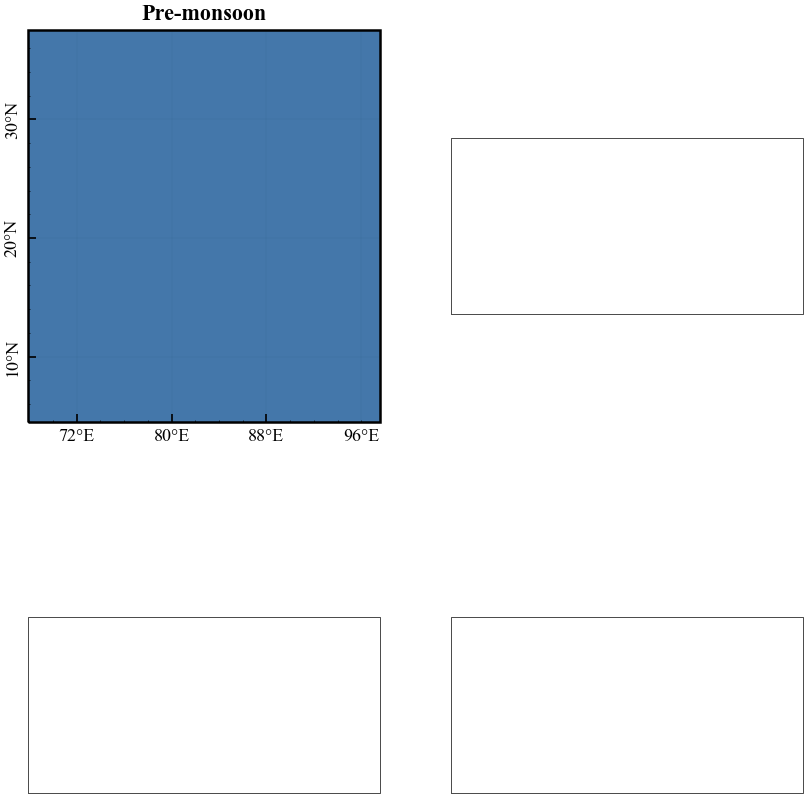

: 

In [12]:
dataset=[]
season=['Pre-monsoon','Monsoon','Post-monsoon','Winter']
#ssn=[[3,4,5],[6,7,8,9],[10,11],[12,1,2]]
for s in season:
    
    #fld_ssn=data['Streamflow_tavg'].sel(time=data["time.month"].isin(s)).resample(time='Y').max()
    #fld=fld_ssn.mean(dim='time')
    #dataset.append(fld)
    dt=dry_wet_ssn['fld_flow'].sel(season=s).compute()
    dataset.append(dt)

plt_tit=season
cbar_tit='Stream flow (Cumic)'
main_tit=''
Map_plot1(dataset,[2,2],plt_tit,cbar_tit)  
plt.savefig(r'2_Streamflow_Analysis\0_Datapreprocessing\Average_flood.jpeg', bbox_inches='tight',dpi=1000)

##  FUNCTIONS

In [8]:
import numpy as np 
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import matplotlib
import xarray as xr
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as clr
import seaborn 
import scienceplots
import matplotlib.ticker as ticker
plt.style.use(['science','no-latex','bright'])

def Map_plot1(xrr,col_row,plt_tit,cbar_tit):

    c=col_row[1]
    r=col_row[0]
    # Define the parameters
    B=5   # THis is the base scale. one figure dimension. All are determined based on this

    bt = 1  # bottom space
    
    fig_len=c*5 
    fig_hg=r*5.2 +bt   #This 1.15 depend on the subplot dimension. This case, height of subplot more than length
    fnt = B*3.2
    pd = B*1.5
    ln_wd = B*0.2
    num_colors = 50; marker_size = 6;marker_size2 = 5;alp = 0.1;alph = 0.05
    basinEdge = 'black';basinEdge1 = 'blue';basinLine = 0.35
    
    fig, axs = plt.subplots(col_row[0],col_row[1],subplot_kw={'projection': ccrs.PlateCarree()},figsize=(fig_len,fig_hg),constrained_layout=False)
    axs=axs.flatten()

    #Adding feature maps
    south_asia=gpd.read_file(r'3_Data\Data_p\3_Shapefiles\south_asia_p.shp')
    riv_map = gpd.read_file('3_Data/DATA_r/3_shapefiles_new/India_streams/India_stream.shp')
    ind_map=gpd.read_file('3_Data/DATA_r/3_shapefiles_new/india_admin/Country/India_country.shp')

    #define plot variables
    vmin1 =xrr[1].quantile(0.1)
    vmax1=xrr[1].quantile(0.95)
    cmap2='Blues'

    #Loop over all of the models
    for i,model in enumerate(range(len(xrr))):

            # Axis setttings
            data=xrr[i]

            axs[i].set_extent([67.90, 97.59,4.5, 37.50], ccrs.PlateCarree())

            axs[i].set_xticks([72,80,88], crs=ccrs.PlateCarree())
            axs[i].set_yticks([10,20,30], crs=ccrs.PlateCarree())
            axs[i].xaxis.set_ticks_position('bottom')
            axs[i].yaxis.set_ticks_position('left')
            axs[i].tick_params(axis='both', labelrotation=90,pad=1,labelsize=7,width=1.2, length=6)
            axs[i].set_xticklabels([])
            axs[i].set_yticklabels([])
            [x.set_linewidth(1.8) for x in axs[i].spines.values()]        #bOUNDARY WIDTHH 

            cmap1 = clr.LinearSegmentedColormap.from_list('blue_to_white', ['lightblue', '#FFFFFF'], N=256)
            gradient = np.linspace(0, 1, 256).reshape(-1, 1)
            axs[i].imshow(gradient, cmap=cmap1, extent=[67.90, 97.59,4.5, 37.50], transform=ccrs.PlateCarree())    

            axs[i].set_title(f"{plt_tit[i]}",fontsize=fnt,pad=pd,fontname='Times New Roman',weight='bold')

            # Customize gridlines (NOTE CARTOPY WONT PROVIDE TICKS, SO WE MANUALLY PROVIDED IN ABOVE LINE)
            gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=0.2, color='black', alpha=0.1, linestyle='-')

            gl.xlabel_style = {"size" : 13,'family': 'Times New Roman','weight': 'normal','rotation': 0}
            gl.ylabel_style = {"size" : 13,'family': 'Times New Roman','weight': 'normal','rotation': 90}
            gl.top_labels = False
            gl.right_labels = False
            gl.xlocator = plt.MaxNLocator(4)  # Adjust the number of x-axis gridlines as needed
            gl.ylocator = plt.MaxNLocator(4) 


            # Adding Mainplo
            Main_plot=data.plot(vmin=vmin1,vmax=vmax1 ,ax=axs[i], cmap=cmap2, add_labels=False, add_colorbar=False) 

            # Adding addition feature 
            south_asia.plot(ax=axs[i],color = 'none',edgecolor = basinEdge,linewidth=basinLine*1.6,alpha=1)
            ind_map.plot(ax=axs[i],color = 'none',linestyle='--',alpha=0.7,linewidth=basinLine)
            riv_map.plot(ax=axs[i],color = 'blue',alpha=0.5,linewidth=basinLine*0.3)


    # Adjust the location of the subplots on the page to make room for the colorbar
    fig.subplots_adjust(bottom=1.5/fig_hg, left=None, top=None, right=None, wspace=1.6/fig_len, hspace=2/fig_hg)  # First lock bottom, while make others None (automatically select), Then change spaces

    # Add a colorbar axis at the bottom of the graph
    cbar_ax = fig.add_axes([0.2, 0.63/fig_hg, 0.6, 0.19/fig_hg])   # left,bottom, widht, height

    # Draw the colorbar
    cbar=fig.colorbar(Main_plot, cax=cbar_ax,orientation='horizontal') #,ticks=[0, 1,5]
    cbar.outline.set_linewidth(2) 
    cbar.ax.tick_params(axis='both',which='both', labelsize=fnt,width=2, length=8) 
    cbar.ax.tick_params(axis='both',which='minor', labelsize=fnt*0.7,width=1, length=4) 
    cbar.ax.xaxis.set_ticks_position('top')
    cbar.ax.xaxis.set_label_position('top')

    cbar.set_label(cbar_tit, fontsize=fnt*1.2, labelpad=-65,weight="bold")#position=(0.5, -0.5)
    cbar.ax.xaxis.label.set_fontweight('bold')

    fig.suptitle(main_tit, fontsize=19, y=0.915, fontweight='bold', fontname='Times New Roman')
    
    #plt.tight_layout()  
    plt.show()